In [13]:
from openai import OpenAI
client = OpenAI(api_key="any-key", base_url="http://mn-dgx01.x5.ru:8000/v1")

In [47]:
from glob import glob
import pymupdf
from tqdm import tqdm
import ast, json
from copy import deepcopy
import pandas as pd
import fitz
from sklearn.metrics import roc_auc_score

In [15]:
paths = glob('../../data/preprocessed/combined_data_preprocessed/interns_preprocessed/*/*.pdf')

In [16]:
def get_eval_reply(messages, print_it=False):
    reply = client.chat.completions.create(
        messages=messages,
        model="x5-airun-medium",
        seed=42,
        #top_k=50,
        top_p=0.95,
        temperature=0.1,
        #max_tokens=1024*4,
        frequency_penalty=0.5,
        #presence_penalty=-0.5,
    ).choices[0].message.content
    return reply

In [17]:
def get_fin_reply(messages, print_it=False):
    reply = client.chat.completions.create(
        messages=messages,
        model="x5-airun-medium",
        seed=42,
        #top_k=50,
        top_p=0.95,
        temperature=0.1,
        max_tokens=200,
        frequency_penalty=0.5,
        presence_penalty=-0.5,
    ).choices[0].message.content
    return reply

In [18]:
def get_text_with_links(document):
    result_text = ""
    
    for page_num in range(len(document)):
        page = document.load_page(page_num)

        # Получаем слова и их координаты
        words = page.get_text("words")
        links = page.get_links()

        # Временный словарь для отслеживания последнего индекса слова для каждого URL
        last_occurrence_with_url = {}

        wc_map = {tuple(word[:4]): word[4] for word in words}
        
        for link in links:
            link_rect = fitz.Rect(link["from"])
            uri = link.get('uri', 'Нет ссылки')
            
            for i, word in enumerate(words):
                text = word[4]   # текст слова
                word_rect = fitz.Rect(word[:4])

                # Проверка на пересечение координат
                if word_rect.intersects(link_rect):
                    last_occurrence_with_url[uri] = (i, tuple(word[:4]))

        # Заменяем текст в конечном словаре ссылками на последних вхождениях
        for uri, (index, rect) in last_occurrence_with_url.items():
            wc_map[rect] = f'{wc_map[rect]}:"{uri}"'

        # Сортировка слов по их координатам для правильного порядка
        sorted_words = sorted(wc_map.items(), key=lambda x: (x[0][1], x[0][0]))

        for item in sorted_words:
            result_text += item[1] + " "
    
    return result_text.strip()  # добавляем strip для удаления лишних пробелов в конце

In [21]:
df = pd.read_csv('../../data/preprocessed/combined_data_preprocessed/interns_preprocessed/interns_preprocessed.csv').dropna().reset_index(drop=True)
df['Резюме'] = df['Резюме'].map(lambda x: '../../data/preprocessed/combined_data_preprocessed/'+x.replace('\\','/'))

In [22]:
with pymupdf.open(df['Резюме'].loc[3]) as doc:
    resume1 = get_text_with_links(doc)
with pymupdf.open(df['Резюме'].loc[4]) as doc:
    resume2 = get_text_with_links(doc)
with pymupdf.open(df['Резюме'].loc[10]) as doc:
    resume3 = get_text_with_links(doc)
with pymupdf.open(df['Резюме'].loc[11]) as doc:
    resume4 = get_text_with_links(doc)
with pymupdf.open(df['Резюме'].loc[19]) as doc:
    resume5 = get_text_with_links(doc)
with pymupdf.open(df['Резюме'].loc[0]) as doc:
    resume6 = get_text_with_links(doc)
with pymupdf.open(df['Резюме'].loc[8]) as doc:
    resume7 = get_text_with_links(doc)
with pymupdf.open(df['Резюме'].loc[307]) as doc:
    resume8 = get_text_with_links(doc)

In [23]:
print(len(resume1))
print(len(resume2))
print(len(resume3))
print(len(resume4))
print(len(resume5))
print(len(resume6))
print(len(resume7))
print(len(resume8))

3238
2682
4701
2011
1058
2591
1472
2850


In [24]:
vacancy = """Позиция: Стажер дата-аналитик 6 вакасий
Компания: Х5 Group 
Формат: Продолжительность стажировки 4-6 месяцев (full-time - 40 часов в неделю!)
Локация: Удаленная работа (но по желанию можно работать из офиса, г. Москва)
Вилки: Оклад 60 тыс.руб. gross 
Начало стажировки: ~сентябрь 2024 г.

💡Команда ad-hoc аналитики из X5 Group (Пятерочка, Перекресток, Чижик и etc) в поисках стажеров! 

🔬Почему у нас интересно? 
Более 20 тысяч магазинов, 15 миллионов клиентов, петабайты данных - и все это нужно анализировать. Каждый день мы показываем, что наши супермаркеты - на самом деле цифровой проект, в котором большое место занимают Big Data и Data-Driven подход. 
Мы в команде ad-hoc аналитики крутим AB-тесты в оффлайне и не только, с каждым днем все больше прилетает нестандартных задачек, в которых мы используем все свои знания (или быстро их приобретаем), а также у нас можно заниматься рисерчами! 

🔭Задачи: 
Чем у нас занимаются стажеры?
- Первое время проходят онбординг, запоминают имена ментора и тим-лида и погружаются в курс дела 
- Сразу после этого получают свою первую настоящую боевую задачку (и НЕ страдают, так как ментор всегда под рукой) на дизайн будущего эксперимента на магазинах или лояльных клиентах или на оценку экономических эффектов от бизнес-инициатив
А если и этого мало, то вот примеры других продуктовых задач и задач на ad-hoc аналитику (в том числе и на ML), с которыми мы имеем дело:
- Разработка модели, определяющей ежедневное оптимальное количество сотрудников магазина
- Разработка алгоритма поиска комплементарных товаров и товаров-аналогов
- Кластеризация магазинов сети на группы похожих по различным параметрам
- Задача по распричиниванию случившихся списаний в магазине (сколько товара списали по причине Х) 
- И многое другое

Ты нам подходишь:
- Если уже загуглил, что такое "ad-hoc" и понял, в чем суть
- Уверенно владеешь Python (pandas, numpy, matplotlib и весь базовый набор для аналитики данных), SQL (join'ы, оконки), знаешь статистику
- Обладаешь аналитическим складом ума, наблюдательностью и успешно практикуешь метод пристального взгляда
- Любишь мемы (желательно, но необязательно)
- Преимуществом будет владение бигдатой и ML

Что мы предлагаем:
- Помощь менторов на всем этапе стажировки
- Классный коллектив, теплая атмосфера и веселые ретро с играми и битвой мемов, а также оффлайн-тимбилдинги

Ответы на 10 важных вопросов:
1. Данные: данных петабайты, стек Hadoop, Hive, Spark. 
2. Железо: под команду 2 сервера под расчеты,  каждый Intel Xeon 32Core 256 GB RAM Bare Metal. 
Данные храним в Hadoop.
Что касаемо ноутбуков - выдаются HP /Macbook Pro/ Dell.
3. Масштаб влияния на core-бизнес? Решаемые задачи затрагивают 20000 магазинов по всей стране.
4. Уровень развития Data Science в компании? Data Science в компании выделен как одно из ключевых направлений.
5. Роль дата сайентиста: полный цикл от понимания бизнес потребности до внедрения решений для решения ее.
6. Бэкграунд у вашего руководителя? linkedin (https://www.linkedin.com/in/amsakhnov/) 
7. Как часто вам будут мешать работать? мешать работать не будем, 3-4 часа регулярных встреч в неделю
8. Карьерный рост: рост по результатам performance review, которые проводятся 2 раза в год.
9. Prod/Research: задача может быть любая, так что research + prod
10. Функция сервиса или лидера? На этапе стажировки 100% сервис.

Свои CV и вопросы направлять сюда: tg @didi_ulyanova"""

In [ ]:
prompt = f"""Объясни почему кандидаты 1, 2 и 3 прошли первый этап собеседования, а другие не смогли, несмотря на внушительное резюме.
Тех собеседование состоит из:
- Решение алгоритмических задач (1 задачa - leetcode easy + 1 задача leetcode medium)
- 1 простая задача на SQL + базовые вопросы по SQL
- Знание основ статистики
- Знание основ ML
- Умение рассуждать

Прошли:
Резюме1: {resume1}
Резюме2: {resume5}
Резюме3: {resume7}

Не прошли:
Резюме4: {resume3}
Резюме5: {resume4}
Резюме6: {resume6}
Резюме7: {resume8}"""

messages = [
    {"role": "user", "content": prompt}
]
crits_reply = get_eval_reply(messages)
print(crits_reply)
messages = [
    {"role": "user", "content": prompt},
    {'role': 'assistant', 'content': crits_reply},
    {"role": "user", "content": """На основе своих рассуждений составь очень очень очень подробные универсальные требования для HR с конкретным указанием сколько баллов в диапозоне должен давать каждый пункт резюме кандидату.
Распиши редфлаги при которых кандидату дается 0 баллов и он отвергается. Распиши когда стоит давать максимум баллов, за что снижать оценку и на сколько. Распиши абсолютно каждый балл. 1 балл за это, еще один за другое, а не по 5 или 15.
Помни что нам самое главное убрать слабых кандидатов, при этом не убрать сильных, так что критериев должно быть много, они должны быть разнообразные и покрывать все возможные аспекты, от опыта работы до стиля написания резюме.
На основе данных критериев алгоритм оценщик должен решить приглашать кандидата на интервью или сразу ему отказать на основании информации из резюме."""},
]
print(get_eval_reply(messages))

In [26]:
criteria = """1. Знание основ статистики и машинного обучения: [0-10 баллов]
    - Знание основных статистических методов и моделей (например, регрессионный анализ, статистическое моделирование, тестирование гипотез). [0-2 балла]
    - Умение применять статистические методы для анализа данных и решения конкретных задач. [0-2 балла]
    - Знание основных алгоритмов и моделей машинного обучения, включая их применение и оценку результатов. [0-3 балла]
    - Опыт разработки и развертывания ML-моделей в производственной среде. [0-3 балла]

2. Умение решать алгоритмические задачи: [0-10 баллов]
    - Способность решать задачи уровня Easy из категории LeetCode или аналогичных ресурсов. [0-2 балла]
	- Способность решать задачи уровня Medium из категории LeetCode или аналогичных ресурсов. [0-3 балла]
    - Умение эффективно использовать алгоритмы и структуры данных для решения задач. [0-2 балла]
    - Опыт решения реальных проблем с помощью алгоритмических подходов. [0-3 балла]

3. Знание SQL и базовые вопросы по SQL: [0-10 баллов]
    - Знание синтаксиса SQL и умение писать запросы для извлечения, преобразования и анализа данных. [0-2 балла]
    - Опыт работы с реляционными базами данных и использование SQL для решения задач. [0-2 балла]
    - Знание продвинутых функций SQL, таких как агрегатные функции, подзапросы и операции соединения. [0-3 балла]
    - Опыт оптимизации SQL-запросов для повышения производительности. [0-3 балла]

4. Знание основ анализа данных и визуализации: [0-10 баллов]
    - Умение проводить анализ данных, включая обработку, очистку и преобразование данных. [0-2 балла]
    - Знание методов визуализации данных для представления результатов анализа. [0-2 балла]
    - Опыт работы с инструментами для визуализации, такими как Matplotlib, Seaborn или Tableau. [0-3 балла]
    - Способность создавать эффективные и понятные визуализации для коммуникации результатов. [0-3 балла]

5. Опыт работы с большими данными и распределенными системами: [0-10 баллов]
    - Знание распределенных систем обработки данных (например, Spark, Hadoop). [0-2 балла]
    - Опыт работы с большими наборами данных и оптимизация запросов для таких данных. [0-2 балла]
    - Знание методов распределенной обработки и обработки данных в реальном времени. [0-3 балла]
    - Опыт работы с кластерами баз данных и оркестраторами, такими как Kubernetes или OpenShift. [0-3 балла]

6. Знание инструментов и библиотек для Data Science: [0-10 баллов]
    - Знание и опыт использования библиотек Python для анализа данных, таких как Pandas, Numpy, Scipy, Sklearn. [0-3 балла]
    - Опыт работы с инструментами ML, такими как PyTorch или TensorFlow. [0-3 балла]
    - Знание и использование инструментов для визуализации и отчетности (например, Matplotlib, Seaborn, Power BI). [0-2 балла]
    - Опыт работы с инструментами для управления версиями и сотрудничества, такими как Git и GitLab. [0-2 балла]

7. Умение работать в команде и коммуникационные навыки: [0-10 баллов]
    - Способность эффективно общаться и сотрудничать с коллегами, клиентами и заказчиками. [0-3 балла]
    - Умение ясно формулировать свои идеи и объяснять технические концепции. [0-2 балла]
    - Опыт работы в команде над проектами по анализу данных или ML. [0-3 балла]
    - Способность принимать и давать конструктивную обратную связь. [0-2 балла]

8. Опыт работы с реальными проектами в области Data Science: [0-20 баллов]
    - Успешное завершение проектов по анализу данных или ML с реальными результатами. [0-8 балла]
    - Опыт работы с различными источниками данных и умение решать проблемы, связанные с качеством и доступностью данных. [0-6 балла]
    - Способность применять полученные знания и навыки для решения реальных бизнес-задач. [0-4 балла]
    - Опыт работы с клиентами и понимание их потребностей. [0-2 балла]"""

In [27]:
criteria2 = """1. Образование и специализация:
   - Наличие высшего образования в области данных, статистики, математики или смежных дисциплин. (10 баллов)
   - Специальность, непосредственно связанная с анализом данных, машинным обучением или информационными технологиями. (5 баллов)

2. Опыт работы:
   - Опыт работы в сфере анализа данных, машинного обучения или смежных областях. (15 баллов)
   - Опыт разработки и реализации проектов в команде. (10 баллов)
   - Понимание бизнес-процессов и умение применять аналитические инструменты для решения практических задач. (10 баллов)

3. Технические навыки:
   - Знание языков программирования: Python, R или другие языки, используемые в области анализа данных. (10 баллов)
   - Опыт работы с библиотеками и фреймворками для анализа данных (pandas, numpy, sklearn и др.). (10 баллов)
   - Знание SQL и базовых вопросов по SQL для взаимодействия с базами данных. (5 баллов)
   - Знание основ статистики и умение применять статистические методы в анализе данных. (10 баллов)
   - Знание основ машинного обучения и опыт работы с популярными библиотеками ML (sklearn, PyTorch и др.). (15 баллов)
   - Умение работать с инструментами визуализации данных (Tableau, Power BI и др.). (5 баллов)

4. Практический опыт и проекты:
   - Наличие успешных проектов в области анализа данных, включая решение алгоритмических задач, разработку моделей и визуализацию результатов. (20 баллов)
   - Опыт работы с большими данными и использование методов машинного обучения для решения практических задач. (15 баллов)
   - Умение работать с различными типами данных (структурированные, неструктурированные) и решать задачи анализа данных. (10 баллов)

5. Коммуникационные навыки:
   - Умение ясно и четко выражать свои идеи и результаты анализа. (5 баллов)
   - Способность работать в команде и эффективно взаимодействовать с коллегами. (5 баллов)

6. Дополнительные навыки:
   - Знание основ DevOps и опыт работы с инструментами CI/CD, такими как Git, GitLab и др. (5 баллов)
   - Опыт работы с инструментами автоматизации и управления проектами (Jira, Confluence и др.). (3 балла)
   - Знание основ бизнес-анализа и умение применять аналитические методы для решения бизнес-задач. (5 баллов)

7. Сертификации и дополнительные курсы:
   - Наличие сертификатов или успешное прохождение курсов по анализу данных, машинному обучению или связанным темам. (5 баллов)

8. Предпочтительные навыки:
   - Опыт работы с инструментами Big Data (Spark, Hadoop и др.). (3 балла)
   - Знание основ Deep Learning и опыт работы с нейронными сетями. (3 балла)
   - Опыт работы в сфере финансов, банковского дела или страхования (предпочтительно). (3 балла)"""

In [28]:
criteria3 = """**Опыт работы:**
- Отсутствие профессионального опыта: 0 баллов.
- Опыт работы в области анализа данных или смежных сферах: 15 баллов.
- Опыт в крупных компаниях или успешные проекты в этой области: 20 баллов.
- Продолжительность опыта и разнообразие проектов: 5-10 баллов (в зависимости от глубины и актуальности опыта).

**Навыки:**
- Python (pandas, numpy, matplotlib): 25 баллов.
   - Полное отсутствие знаний: 0 баллов.
   - Базовое знание: 5 баллов.
   - Понимание и использование в проектах: 15 баллов.
   - Глубокое знание и опыт работы с различными библиотеками Python: 25 баллов.

- SQL (базовые знания): 10 баллов.
   - Нулевые знания: 0 баллов.
   - Умение писать базовые запросы: 5 баллов.
   - Опыт работы с SQL в профессиональных проектах: 10 баллов.

- Статистика: 15 баллов.
   - Отсутствие знаний: 0 баллов.
   - Знание базовых статистических методов: 5 баллов.
   - Применение статистики в анализе данных: 10 баллов.
   - Глубокие знания и опыт в применении сложных статистических моделей: 15 баллов.

- Машинное обучение (ML): 20 баллов.
   - Отсутствие знаний: 0 баллов.
   - Понимание основных концепций ML: 5 баллов.
   - Опыт работы с классическими ML-моделями: 10 баллов.
   - Глубокое изучение и применение нейронных сетей: 20 баллов.

- Другие навыки (Git, MLops, визуализация данных): 5-15 баллов (в зависимости от важности навыка для вакансии).

**Образование и курсы:**
- Высшее образование в области информатики, математики или смежных дисциплин: 10 баллов.
- Магистратура или дополнительное обучение в сфере анализа данных/ML: 5-10 баллов (в зависимости от актуальности и качества образования).
- Сертификаты и курсы по ML, статистике или связанным областям: 5-10 баллов (в зависимости от качества и актуальности курсов).

**Проекты и достижения:**
- Успешные проекты в области анализа данных, ML или смежных областях: 20-30 баллов (в зависимости от сложности и актуальности проектов).
- Опыт участия в хакатонах или исследовательских проектах: 10-15 баллов (в зависимости от масштаба и успешности проектов).
- Опубликованные работы или статьи в области анализа данных: 15-20 баллов.
- Личные достижения и награды в области анализа данных/ML: 5-10 баллов.

**Дополнительные факторы:**
- Знание английского языка (B2 и выше): 5 баллов.
- Мотивированность, стремление к развитию и увлечение сферой анализа данных: 5 баллов.
- Предыдущие рекомендации и отзывы о кандидате: 5-10 баллов (в зависимости от качества и количества рекомендаций).

**Редфлаги при нулевой оценке:**
- Отсутствие или недостаточный уровень опыта работы в области анализа данных.
- Отсутствие знаний в ключевых областях, таких как Python, SQL или статистика.
- Нулевой опыт или недостаточная мотивация в области ML.
- Отсутствие проектов или практического опыта в анализе данных.
- Нулевые знания английского языка.

**Максимальная оценка и ее факторы:**
- Кандидат имеет богатый опыт работы в крупных компаниях, таких как Сбербанк или X5 Group.
- Отличные результаты в проектах, продемонстрировавшие успешное применение методов анализа данных и ML.
- Глубокие знания и опыт в нескольких областях, таких как Python, SQL, ML и визуализация данных.
- Активное участие в исследовательских проектах и хакатонах с успешными результатами.
- Высокий уровень английского языка, позволяющий свободно общаться и работать с иностранными источниками.

**Снижение оценки:**
- Недостаточный опыт работы в области анализа данных или отсутствие конкретных примеров успешных проектов.
- Плохие результаты в тестовых заданиях или недостаточное понимание ключевых концепций.
- Отсутствие или слабое знание статистических методов и их применения.
- Недостаточный опыт в работе с базами данных или SQL.
- Нехватка мотивации или отсутствие увлечения сферой анализа данных.
"""

In [29]:
criteria4 = """**Опыт работы в области Data Science и ML:**
- Опыт работы в качестве Data Scientist, Data Analyst или схожей должности - 5 баллов.
  - Редфлаг: Отсутствие опыта в данных областях - 0 баллов.
- Разработка продуктов или проектов в области Data Science/ML - 4 балла.
  - Применяемые технологии:
    - Python - 1 балл за каждый год опыта.
    - SQL - 1 балл за каждый год опыта.
    - ML библиотеки (sklearn, XGBoost и др.) - 1 балл за каждый год опыта.
    - Другие языки/библиотеки (R, Spark и др.) - 0,5 балла за каждый год опыта.
- Участие в хакатонах или конкурсах по Data Science - 3 балла.
  - Максимум баллов присуждается за победу или высокое место в соревнованиях.

**Навыки и знания:**
- Python - 5 баллов.
  - Редфлаг: Отсутствие опыта в Python или недостаточный уровень - 0 баллов.
  - Обязательно умение использовать библиотеки для анализа данных (pandas, numpy и др.) - 1 балл.
  - Опыт в разработке веб-сервисов или ботов - 1 балл.
- SQL - 4 балла.
  - Базовые знания SQL и работа с базами данных - 2 балла.
  - Опыт написания сложных запросов и оптимизации баз данных - 1 балл.
  - Знание технологий для администрирования и управления базами данных (PostgreSQL, MySQL и др.) - 1 балл.
- Machine Learning - 5 баллов.
  - Знание основных ML-алгоритмов и моделей - 2 балла.
  - Опыт в применении ML для решения практических задач - 2 балла.
  - Знание MLOps и инструментов (poetry, Ruff, MyPy и др.) - 1 балл.
- Статистика - 3 балла.
  - Базовые знания статистики и вероятности - 1 балл.
  - Опыт применения статистических методов в анализе данных - 1,5 балла.
  - Знание продвинутых статистических методов (например, EDA, A/B тестирование) - 0,5 балла.
- Другие навыки (Git, Bash, Docker и др.) - до 3 баллов.
  - Каждый год опыта в использовании таких инструментов - 0,5 балла.

**Образование:**
- Высшее образование в области компьютерных наук, математики, статистики или смежных дисциплин - 3 балла.
  - Редфлаг: Отсутствие соответствующего образования или не указание учебного заведения - 0 баллов.
- Сертификаты и курсы по Data Science/ML - до 2 баллов.
  - Каждое завершенное качественное обучение - 0,5 балла.

**Проекты и достижения:**
- Завершенные проекты в области Data Science/ML - до 5 баллов.
  - Каждый проект с реальным применением - 1 балл.
  - Использование продвинутых методов (например, A/B тестирование, ML-модели) - 1 балл.
  - Представление проекта в виде репозитория с документацией - 1 балл.
  - Подтверждение отраслевыми экспертами или публикация результатов - 1 балл.
- Научные работы, публикации, участие в конференциях - до 3 баллов.
  - Каждая публикация или выступление - 1 балл.

**Опыт работы:**
- Опыт работы в крупных компаниях в качестве Data Scientist, Data Analyst или смежных ролях - до 4 баллов.
  - Каждый год опыта работы - 1 балл.
  - Работа с большими данными или сложными задачами - 0,5 балла.
- Сопровождение и поддержка продуктов/проектов - 2 балла.
  - Опыт сопровождения проектов от начала до конца - 1 балл.
  - Опыт работы с клиентами или заказчиками - 0,5 балла.

**Языки и навыки общения:**
- Английский язык - 2 балла.
  - Уровень выше среднего (B2 и выше) - 1 балл.
  - Отличное знание английского (C1, C2) - 2 балла.
  - Редфлаг: Отсутствие указания уровня владения или уровень ниже среднего - 0 баллов.
- Другие языки (например, русский, французский) - до 1 балла.
  - Уровень выше среднего - 0,5 балла за каждый язык.
- Навыки общения и презентации проектов - 1 балл.
  - Успешные примеры презентаций или публичных выступлений - 1 балл.

**Стиль резюме и презентация себя:**
- Структура и содержание резюме - 2 балла.
  - Подробное и структурированное резюме, содержащее все необходимые разделы (образование, навыки, опыт работы, проекты и т.д.) - 1 балл.
  - Использование конкретных примеров и результатов - 0,5 балла.
  - Редфлаг: Необоснованные утверждения, отсутствие конкретных примеров или несоответствие между опытом и указанным уровнем - 0 баллов.
- Правильность и грамотность текста - 1 балл.
  - Отсутствие грамматических и орфографических ошибок - 0,5 балла.
  - Правильная структура предложений и понятное изложение - 0,5 балла.
- Полнота информации - 1 балл.
  - Указание конкретных инструментов, технологий и методов, использованных в проектах - 0,5 балла.
  - Описание ролей и обязанностей в опыте работы - 0,5 балла."""

In [30]:
criteria5 = """1. **Опыт работы в анализе данных и машинном обучении (до 50 баллов):**
   - Имеется опыт работы в данных сферах (до 10 баллов): 1 балл за каждый год опыта, но не более 10 баллов.
   - Редфлаг: Отсутствие опыта в анализе данных и машинном обучении.
   - Максимум баллов: Кандидат с опытом более 5 лет в данных сферах.
   - Снижение оценки: Отсутствие подробностей об опыте работы или краткое описание обязанностей.

2. **Решение алгоритмических задач (до 20 баллов):**
   - Успешное решение задач уровня LeetCode Easy и Medium (до 10 баллов): 1 балл за каждую решенную задачу.
   - Редфлаг: Отсутствие упоминания о решении алгоритмических задач или неудачные попытки решения.
   - Максимум баллов: Кандидат успешно решает сложные алгоритмические задачи (LeetCode Hard).
   - Снижение оценки: Решение только простых задач или отсутствие подробностей о решении.

3. **Знание SQL и базовые вопросы по SQL (до 15 баллов):**
   - Знание SQL на базовом уровне (до 10 баллов): 1 балл за каждый указанный навык или проект с SQL.
   - Редфлаг: Отсутствие упоминания о знании SQL или ошибочные SQL-запросы.
   - Максимум баллов: Кандидат демонстрирует глубокие знания SQL, включая сложные запросы и понимание оптимизации.
   - Снижение оценки: Основное знание SQL или отсутствие примеров использования в проектах.

4. **Знание основ статистики (до 10 баллов):**
   - Понимание основ теории вероятности и статистики (до 5 баллов): 1 балл за каждую указанную область статистики.
   - Редфлаг: Отсутствие упоминания о знании статистики или неправильное понимание базовых статистических концепций.
   - Максимум баллов: Кандидат демонстрирует глубокие знания статистики, включая применение статистических методов в проектах.
   - Снижение оценки: Основное знание статистики или отсутствие примеров практического применения.

5. **Знание основ ML (до 20 баллов):**
   - Понимание базовых концепций ML (до 10 баллов): 1 балл за каждую указанную библиотеку или фреймворк ML.
   - Редфлаг: Отсутствие упоминания о знании ML или неправильное понимание базовых методов.
   - Максимум баллов: Кандидат демонстрирует глубокие знания ML, включая опыт в разработке и обучении моделей.
   - Снижение оценки: Основное знание ML или отсутствие примеров практической работы с моделями.

6. **Умение рассуждать (до 10 баллов):**
   - Способность логически рассуждать и анализировать задачи (до 5 баллов): 1 балл за каждый пример успешного решения сложной задачи.
   - Редфлаг: Отсутствие упоминания о навыках критического мышления или затруднения при описании решений.
   - Максимум баллов: Кандидат демонстрирует способность рассуждать на высоком уровне, показывая умение решать сложные проблемы.
   - Снижение оценки: Базовые навыки рассуждения или отсутствие примеров сложных решений.

7. **Опыт работы (до 20 баллов):**
   - Опыт работы в соответствующей области (до 15 баллов): 1 балл за каждый год опыта работы в анализе данных или ML.
   - Редфлаг: Отсутствие опыта работы или работа в несвязанной с анализом данных сфере.
   - Максимум баллов: Кандидат с опытом более 5 лет в соответствующей области.
   - Снижение оценки: Опыт работы в связанной области, но с коротким периодом или без конкретных примеров успешных проектов.

8. **Уровень образования (до 10 баллов):**
   - Высшее образование в соответствующей области (до 5 баллов): 1 балл за получение степени бакалавра или магистра в области, связанной с анализом данных или ML.
   - Редфлаг: Отсутствие соответствующего образования или образование в несвязанной области.
   - Максимум баллов: Кандидат имеет степень магистра в соответствующей области с отличными результатами.
   - Снижение оценки: Образование в соответствующей области, но с низкими оценками или без указания конкретных курсов, связанных с анализом данных.

9. **Навыки и технологии (до 30 баллов):**
   - Знание и опыт использования соответствующих технологий (до 20 баллов): 1 балл за каждый указанный язык программирования или технологию (Python, SQL, ML библиотеки, фреймворки и т.д.).
   - Редфлаг: Отсутствие упоминания о навыках и технологиях или указание устаревших технологий.
   - Максимум баллов: Кандидат владеет широким спектром современных технологий и имеет опыт их применения в проектах.
   - Снижение оценки: Знание только базовых технологий или отсутствие примеров их практического использования.

10. **Проекты и достижения (до 20 баллов):**
    - Описание успешных проектов или достижений в области анализа данных или ML (до 10 баллов): 1 балл за каждый описанный проект с подробностями о решенных задачах и полученных результатах.
    - Редфлаг: Отсутствие упоминания о проектах или проекты с ограниченным описанием.
    - Максимум баллов: Кандидат имеет многочисленные успешные проекты с инновационными решениями и впечатляющими результатами.
    - Снижение оценки: Проекты с ограниченным описанием или отсутствие примеров успешных решений.

11. **Глубина знания тем (до 15 баллов):**
    - Глубокое понимание концепций анализа данных, машинного обучения и связанных технологий (до 10 баллов): 1 балл за каждую указанную концепцию с подробным описанием.
    - Редфлаг: Отсутствие упоминания о глубоком понимании концепций или поверхностное знание.
    - Максимум баллов: Кандидат демонстрирует глубокое и детальное знание концепций, может объяснять сложные идеи и их практическое применение.
    - Снижение оценки: Базовое знание концепций или отсутствие примеров их применения в проектах.

12. **Стиль написания резюме (до 5 баллов):**
    - Четкое, структурированное и подробное резюме (до 5 баллов): 1 балл за четкость и структурированность резюме, дополнительный балл за подробное описание проектов и навыков.
    - Редфлаг: Слишком краткое или неструктурированное резюме, отсутствие подробностей о проектах и навыках.
    - Максимум баллов: Кандидат предоставляет четкое, детальное резюме с хорошо структурированной информацией.
    - Снижение оценки: Резюме с ошибками, отсутствием необходимой информации или нечетким описанием.

13. **Языки программирования (до 10 баллов):**
    - Знание и опыт работы с соответствующими языками программирования (до 10 баллов): 1 балл за каждый указанный язык (Python, R, Java и т.д.).
    - Редфлаг: Отсутствие упоминания о знании языков программирования или указание устаревших языков.
    - Максимум баллов: Кандидат владеет несколькими современными языками программирования, которые широко используются в анализе данных и ML.
    - Снижение оценки: Знание только одного языка или отсутствие примеров использования в проектах.

14. **Библиотеки и фреймворки (до 10 баллов):**
    - Опыт работы с соответствующими библиотеками и фреймворками (до 10 баллов): 1 балл за каждую указанную библиотеку или фреймворк (pandas, sklearn, TensorFlow и т.д.).
    - Редфлаг: Отсутствие упоминания о библиотеках и фреймворках или указание устаревших инструментов.
    - Максимум баллов: Кандидат имеет опыт работы с широким спектром современных библиотек и фреймворков, показывая глубокое понимание их применения.
    - Снижение оценки: Знание только базовых библиотек или отсутствие примеров практического использования.

15. **Качество резюме (до 5 баллов):**
    - Резюме, написанное профессионально и без ошибок (до 5 баллов): 1 балл за отсутствие орфографических и грамматических ошибок, дополнительный балл за четкое и логичное описание опыта и навыков.
    - Редфлаг: Слишком длинное или неструктурированное резюме, наличие грамматических и орфографических ошибок.
    - Максимум баллов: Кандидат предоставляет четкое, лаконичное резюме без ошибок, с хорошо структурированной информацией и подробными примерами.
    - Снижение оценки: Резюме с ошибками, отсутствие четкого описания опыта и навыков.

16. **Уровень английского языка (до 5 баллов):**
    - Знание английского языка на уровне, достаточном для работы в международной среде (до 5 баллов): 1 балл за указание уровня английского (Intermediate или выше).
    - Редфлаг: Отсутствие упоминания о знании английского или указание низкого уровня (A1, A2).
    - Максимум баллов: Кандидат владеет английским языком на высоком уровне (C1, C2), что позволяет эффективно общаться и работать с международной командой.
    - Снижение оценки: Базовый уровень английского или отсутствие упоминания о знании языка.

17. **Портфолио проектов (до 10 баллов):**
    - Наличие портфолио проектов в области анализа данных, показывающих успешное применение навыков в реальных задачах (до 10 баллов): 1 балл за каждый описанный проект с подробным описанием задач, решений и результатов.
    - Редфлаг: Отсутствие портфолио или проекты с ограниченным описанием.
    - Максимум баллов: Кандидат предоставляет портфолио с несколькими проектами, демонстрирующими успешное решение сложных задач и получение впечатляющих результатов.
    - Снижение оценки: Портфолио с нечетким описанием или отсутствие примеров успешных проектов.

18. **Умение работать с распределенными вычислительными системами (до 5 баллов):**
    - Опыт работы с распределенными вычислительными системами, такими как Spark или Hadoop (до 5 баллов): 1 балл за каждый тип распределенной системы, с которой кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с распределенными системами или проблемы с их использованием.
    - Максимум баллов: Кандидат демонстрирует опыт работы с распределенными вычислительными системами, умение оптимизировать вычисления и эффективно использовать ресурсы.
    - Снижение оценки: Опыт работы с распределенными системами, но без подробностей или проблемы с пониманием распределенных вычислений.

19. **Умение работать в команде (до 5 баллов):**
    - Опыт работы в команде и навыки эффективного сотрудничества (до 5 баллов): 1 балл за каждый указанный проект с описанием роли кандидата в команде.
    - Редфлаг: Отсутствие упоминания о работе в команде или негативные отзывы о сотрудничестве.
    - Максимум баллов: Кандидат демонстрирует сильные навыки работы в команде, умение решать конфликты и эффективное распределение задач.
    - Снижение оценки: Опыт работы в команде, но без конкретных примеров успешного сотрудничества.

20. **Общий уровень знаний (до 15 баллов):**
    - Общий уровень знаний в области анализа данных, машинного обучения и связанных тем (до 15 баллов): 1 балл за каждую указанную тему с подробным описанием.
    - Редфлаг: Отсутствие упоминания о знании основополагающих концепций или поверхностное знание.
    - Максимум баллов: Кандидат демонстрирует глубокое и разностороннее знание областей, связанных с анализом данных и ML, включая математические основы, обработку данных, визуализацию и т.д.
    - Снижение оценки: Базовый уровень знаний или отсутствие примеров применения знаний в практических задачах.

21. **Навыки решения проблем (до 10 баллов):**
    - Умение решать сложные задачи и находить инновационные решения (до 10 баллов): 1 балл за каждый пример успешного решения сложной проблемы.
    - Редфлаг: Отсутствие упоминания о навыках решения проблем или описание простых задач.
    - Максимум баллов: Кандидат демонстрирует способность решать сложные, нестандартные задачи, показывая креативность и критическое мышление.
    - Снижение оценки: Опыт решения задач, но без описания сложных или инновационных решений.

22. **Инновационность и творческий подход (до 5 баллов):**
    - Инновационный подход к решению задач и творческое мышление (до 5 баллов): 1 балл за каждый пример инновационного решения или творческого подхода.
    - Редфлаг: Отсутствие упоминания об инновациях или описание стандартных решений.
    - Максимум баллов: Кандидат демонстрирует способность к нестандартному мышлению, предлагая оригинальные решения и подходы.
    - Снижение оценки: Опыт решения задач, но без описания инновационных или творческих решений.

23. **Готовность к обучению (до 5 баллов):**
    - Готовность к постоянному обучению и развитию навыков (до 5 баллов): 1 балл за описание курсов, вебинаров или книг, которые кандидат изучал для развития.
    - Редфлаг: Отсутствие упоминания о желании учиться или отсутствие примеров саморазвития.
    - Максимум баллов: Кандидат активно участвует в обучении, посещает конференции, участвует в онлайн-курсах и стремится совершенствовать свои навыки.
    - Снижение оценки: Готовность к обучению, но без конкретных примеров или ограниченный опыт саморазвития.

24. **Взаимодействие с клиентами (до 5 баллов):**
    - Опыт работы с клиентами и понимание их потребностей (до 5 баллов): 1 балл за каждый проект с описанием взаимодействия с клиентами и успешного удовлетворения их потребностей.
    - Редфлаг: Отсутствие упоминания о работе с клиентами или негативный опыт взаимодействия.
    - Максимум баллов: Кандидат демонстрирует сильные навыки коммуникации, умение понимать потребности клиентов и находить эффективные решения.
    - Снижение оценки: Опыт работы с клиентами, но без подробного описания успешных взаимодействий.

25. **Умение работать с большими объемами данных (до 10 баллов):**
    - Опыт работы с большими объемами данных и умение эффективно их обрабатывать (до 10 баллов): 1 балл за каждый проект с описанием работы с большими данными.
    - Редфлаг: Отсутствие упоминания о работе с большими данными или затруднения при работе с ними.
    - Максимум баллов: Кандидат демонстрирует опыт работы с большими объемами данных, эффективное использование инструментов и методов обработки.
    - Снижение оценки: Опыт работы с данными, но без описания сложных или масштабных проектов.

26. **Понимание бизнес-задач (до 5 баллов):**
    - Понимание бизнес-процессов и умение применять аналитические навыки для решения бизнес-задач (до 5 баллов): 1 балл за каждый проект с описанием решения бизнес-проблемы.
    - Редфлаг: Отсутствие упоминания о понимании бизнес-задач или затруднения при их решении.
    - Максимум баллов: Кандидат демонстрирует глубокое понимание бизнес-процессов и умение применять аналитические инструменты для улучшения бизнес-результатов.
    - Снижение оценки: Опыт работы в бизнес-среде, но без конкретных примеров успешного решения бизнес-задач.

27. **Взаимодействие с другими специалистами (до 5 баллов):**
    - Умение взаимодействовать с другими специалистами, такими как аналитики, разработчики, бизнес-аналитики (до 5 баллов): 1 балл за каждый проект с описанием успешного взаимодействия.
    - Редфлаг: Отсутствие упоминания о взаимодействии с другими специалистами или затруднения в коммуникации.
    - Максимум баллов: Кандидат демонстрирует сильные навыки взаимодействия, умение работать в междисциплинарных командах и эффективно общаться с разными специалистами.
    - Снижение оценки: Опыт работы в команде, но без описания успешного взаимодействия с другими специалистами.

28. **Умение работать с документацией (до 5 баллов):**
    - Умение писать четкую и понятную документацию для проектов (до 5 баллов): 1 балл за каждый проект с подробной документацией.
    - Редфлаг: Отсутствие упоминания о написании документации или нечеткая документация.
    - Максимум баллов: Кандидат демонстрирует умение создавать подробную и структурированную документацию, облегчающую понимание проектов.
    - Снижение оценки: Наличие документации, но с ограниченным описанием или отсутствие документации.

29. **Этика и конфиденциальность данных (до 5 баллов):**
    - Понимание этических аспектов работы с данными и соблюдение конфиденциальности (до 5 баллов): 1 балл за описание понимания этических вопросов и политики конфиденциальности.
    - Редфлаг: Отсутствие упоминания об этике или непонимание важности конфиденциальности данных.
    - Максимум баллов: Кандидат демонстрирует глубокое понимание этических вопросов, соблюдает конфиденциальность данных и следит за безопасностью информации.
    - Снижение оценки: Понимание этических вопросов, но без конкретных примеров соблюдения конфиденциальности.

30. **Умение работать с различными типами данных (до 10 баллов):**
    - Опыт работы с различными типами данных, включая структурированные и неструктурированные данные (до 10 баллов): 1 балл за каждый тип данных, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с различными типами данных или затруднения при работе с ними.
    - Максимум баллов: Кандидат демонстрирует опыт работы с широким спектром типов данных и умение эффективно обрабатывать и анализировать их.
    - Снижение оценки: Опыт работы с ограниченным набором типов данных или отсутствие примеров успешной обработки и анализа.

31. **Навыки презентации и общения (до 5 баллов):**
    - Умение четко и ясно представлять свои идеи и проекты (до 5 баллов): 1 балл за каждый успешный пример презентации или публичного выступления.
    - Редфлаг: Отсутствие упоминания о навыках презентации или проблемы с коммуникацией.
    - Максимум баллов: Кандидат демонстрирует сильные навыки презентации, умение ясно и доступно объяснять сложные концепции.
    - Снижение оценки: Наличие опыта презентации, но без подробностей или ограниченный опыт публичных выступлений.

32. **Умение работать под давлением и в условиях ограничений (до 5 баллов):**
    - Опыт работы в условиях ограничений, таких как сжатые сроки или ограниченные ресурсы (до 5 баллов): 1 балл за каждый проект с описанием успешной работы в стрессовых ситуациях.
    - Редфлаг: Отсутствие упоминания о работе под давлением или трудности в таких условиях.
    - Максимум баллов: Кандидат демонстрирует способность работать эффективно в стрессовых ситуациях, находить решения в условиях ограничений.
    - Снижение оценки: Опыт работы в условиях ограничений, но без подробного описания успешных стратегий решения проблем.

33. **Гибкость и адаптивность (до 5 баллов):**
    - Умение адаптироваться к изменениям и работать в быстро меняющихся условиях (до 5 баллов): 1 балл за каждый проект с описанием успешной адаптации к новым условиям.
    - Редфлаг: Отсутствие упоминания о способности к адаптации или проблемы с адаптацией в новых условиях.
    - Максимум баллов: Кандидат демонстрирует гибкость, умение быстро реагировать на изменения и находить альтернативные решения.
    - Снижение оценки: Опыт работы в меняющихся условиях, но без подробностей о стратегиях адаптации.

34. **Навыки лидерства (до 5 баллов):**
    - Опыт руководства проектами или командами (до 5 баллов): 1 балл за каждый проект с описанием успешного руководства.
    - Редфлаг: Отсутствие упоминания о лидерских качествах или проблемы с руководством.
    - Максимум баллов: Кандидат демонстрирует сильные лидерские качества, умение вдохновлять и мотивировать команду, эффективно распределять задачи и достигать целей.
    - Снижение оценки: Опыт руководства, но без подробностей об успешном руководстве или негативные отзывы о лидерских качествах.

35. **Умение работать с версионным контролем (до 5 баллов):**
    - Опыт работы с системами версионного контроля, такими как Git (до 5 баллов): 1 балл за каждый проект с использованием Git или другого версионного контроля.
    - Редфлаг: Отсутствие упоминания о версионном контроле или проблемы с использованием Git.
    - Максимум баллов: Кандидат демонстрирует глубокое понимание версионного контроля, умение работать с разными ветками и эффективно использовать инструменты для контроля изменений.
    - Снижение оценки: Опыт работы с Git, но без подробностей или проблемы с использованием систем версионного контроля.

36. **Умение работать с сетями и системами распределенных вычислений (до 5 баллов):**
    - Опыт работы с сетями и распределенными системами (до 5 баллов): 1 балл за каждый проект с использованием сетей и распределенных вычислений.
    - Редфлаг: Отсутствие упоминания о работе с сетями или проблемы при использовании распределенных систем.
    - Максимум баллов: Кандидат демонстрирует опыт работы с сетями и распределенными системами, умение оптимизировать вычисления и эффективно использовать ресурсы.
    - Снижение оценки: Опыт работы с сетями, но без подробностей или проблемы с пониманием распределенных вычислений.

37. **Умение работать с инструментами визуализации (до 5 баллов):**
    - Опыт работы с инструментами визуализации данных, такими как Tableau, Power BI или Plotly (до 5 баллов): 1 балл за каждый проект с использованием инструментов визуализации.
    - Редфлаг: Отсутствие упоминания о работе с инструментами визуализации или проблемы с визуализацией данных.
    - Максимум баллов: Кандидат демонстрирует опыт создания эффективных визуализаций, умение выбирать правильные методы визуализации и эффективно представлять данные.
    - Снижение оценки: Опыт работы с инструментами визуализации, но без подробностей или проблемы с созданием информативных визуализаций.

38. **Навыки управления проектами (до 5 баллов):**
    - Опыт управления проектами, включая планирование, организацию и контроль задач (до 5 баллов): 1 балл за каждый проект с описанием успешного управления.
    - Редфлаг: Отсутствие упоминания о навыках управления проектами или проблемы с организацией и контролем задач.
    - Максимум баллов: Кандидат демонстрирует сильные навыки управления проектами, умение планировать ресурсы, эффективно распределять задачи и управлять рисками.
    - Снижение оценки: Опыт управления проектами, но без подробностей или проблемы с организацией и контролем.

39. **Умение работать с базами данных (до 10 баллов):**
    - Опыт работы с различными типами баз данных, включая SQL и NoSQL (до 10 баллов): 1 балл за каждый тип базы данных, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с базами данных или проблемы с пониманием баз данных.
    - Максимум баллов: Кандидат демонстрирует опыт работы с различными типами баз данных, умение оптимизировать запросы и эффективно использовать базы данных в проектах.
    - Снижение оценки: Опыт работы с базами данных, но без подробностей или проблемы с оптимизацией запросов.

40. **Умение работать с естественным языком (до 5 баллов):**
    - Опыт работы с естественным языком и понимание его роли в ML (до 5 баллов): 1 балл за каждый проект с использованием методов обработки естественного языка.
    - Редфлаг: Отсутствие упоминания о работе с естественным языком или проблемы с пониманием его роли в ML.
    - Максимум баллов: Кандидат демонстрирует опыт работы с обработкой естественного языка, умение применять методы NLP и понимание его применения в ML-задачах.
    - Снижение оценки: Опыт работы с естественным языком, но без подробностей или проблемы с применением методов NLP.

41. **Навыки управления временем (до 5 баллов):**
    - Умение эффективно управлять временем и задачами (до 5 баллов): 1 балл за каждый проект с описанием успешного управления временем и приоритетами.
    - Редфлаг: Отсутствие упоминания о навыках управления временем или проблемы с организацией задач.
    - Максимум баллов: Кандидат демонстрирует умение планировать и приоритезировать задачи, эффективно распределяя время и ресурсы.
    - Снижение оценки: Опыт управления временем, но без подробностей или проблемы с организацией задач.

42. **Умение работать с документацией API (до 5 баллов):**
    - Опыт работы с документацией API и умение использовать их для решения задач (до 5 баллов): 1 балл за каждый проект с использованием API.
    - Редфлаг: Отсутствие упоминания о работе с API или проблемы с пониманием документации.
    - Максимум баллов: Кандидат демонстрирует опыт работы с различными API, умение интерпретировать документацию и эффективно использовать API в решении задач.
    - Снижение оценки: Опыт работы с API, но без подробностей или проблемы с пониманием документации.

43. **Умение работать с различными операционными системами (до 5 баллов):**
    - Опыт работы с различными операционными системами, такими как Windows, Linux или macOS (до 5 баллов): 1 балл за каждый тип операционной системы, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с различными ОС или проблемы с переходом между ними.
    - Максимум баллов: Кандидат демонстрирует опыт работы с несколькими ОС, умение адаптироваться к разным средам и эффективно использовать инструменты каждой ОС.
    - Снижение оценки: Опыт работы с ОС, но без подробностей или проблемы с адаптацией к новым ОС.

44. **Умение работать с облаками (до 5 баллов):**
    - Опыт работы с облачными платформами, такими как AWS, Google Cloud или Azure (до 5 баллов): 1 балл за каждый облачный сервис, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с облаками или проблемы с использованием облачных сервисов.
    - Максимум баллов: Кандидат демонстрирует опыт работы с облачными платформами, умение выбирать правильные инструменты и эффективно использовать ресурсы облака.
    - Снижение оценки: Опыт работы с облаками, но без подробностей или проблемы с пониманием облачных технологий.

45. **Умение работать с большими объемами данных в реальном времени (до 10 баллов):**
    - Опыт работы с большими объемами данных в реальном времени (до 10 баллов): 1 балл за каждый проект с описанием работы с большими данными в реальном времени.
    - Редфлаг: Отсутствие упоминания о работе с большими данными в реальном времени или проблемы с обработкой таких данных.
    - Максимум баллов: Кандидат демонстрирует опыт работы с большими данными в реальном времени, умение использовать инструменты для эффективной обработки и анализа данных.
    - Снижение оценки: Опыт работы с большими данными, но без описания проектов в реальном времени или проблемы с обработкой больших данных.

46. **Умение работать с неструктурированными данными (до 5 баллов):**
    - Опыт работы с неструктурированными данными, такими как текст, аудио, видео (до 5 баллов): 1 балл за каждый тип неструктурированных данных, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с неструктурированными данными или проблемы с обработкой таких данных.
    - Максимум баллов: Кандидат демонстрирует опыт работы с различными типами неструктурированных данных и умение использовать соответствующие методы для их обработки и анализа.
    - Снижение оценки: Опыт работы с неструктурированными данными, но без подробностей или проблемы с обработкой таких данных.

47. **Навыки планирования и стратегии (до 5 баллов):**
    - Умение разрабатывать стратегии и планы для достижения целей проекта (до 5 баллов): 1 балл за каждый проект с описанием успешной разработки стратегии.
    - Редфлаг: Отсутствие упоминания о навыках планирования или проблемы с разработкой стратегий.
    - Максимум баллов: Кандидат демонстрирует умение разрабатывать эффективные стратегии, умение планировать ресурсы и задачи для достижения целей.
    - Снижение оценки: Опыт планирования, но без подробностей или проблемы с разработкой стратегий.

48. **Умение работать с данными в реальном времени (до 5 баллов):**
    - Опыт работы с данными в реальном времени, такими как потоки данных или интернет-данные (до 5 баллов): 1 балл за каждый проект с описанием работы с данными в реальном времени.
    - Редфлаг: Отсутствие упоминания о работе с данными в реальном времени или проблемы с обработкой таких данных.
    - Максимум баллов: Кандидат демонстрирует опыт работы с данными в реальном времени, умение использовать соответствующие инструменты и методы для анализа и обработки данных в режиме реального времени.
    - Снижение оценки: Опыт работы с данными в реальном времени, но без подробностей или проблемы с обработкой таких данных.

49. **Умение работать с графами и сетевыми структурами данных (до 5 баллов):**
    - Опыт работы с графами и сетевыми структурами данных, такими как сети, графы или дерево решений (до 5 баллов): 1 балл за каждый тип графов или структур данных, с которыми кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с графами или проблемами с обработкой таких структур.
    - Максимум баллов: Кандидат демонстрирует опыт работы с графами и сетевыми структурами данных, умение применять соответствующие алгоритмы и методы для анализа и обработки данных.
    - Снижение оценки: Опыт работы с графами, но без подробностей или проблемы с пониманием структуры данных."""

In [31]:
criteria6 = """1. **Опыт работы в анализе данных и машинном обучении (до 50 баллов):**
   - Имеется опыт работы в данных сферах (до 10 баллов): 1 балл за каждый год опыта, но не более 10 баллов.
   - Редфлаг: Отсутствие опыта в анализе данных и машинном обучении.
   - Максимум баллов: Кандидат с опытом более 5 лет в данных сферах.
   - Снижение оценки: Отсутствие подробностей об опыте работы или краткое описание обязанностей.

2. **Решение алгоритмических задач (до 20 баллов):**
   - Успешное решение задач уровня LeetCode Easy и Medium (до 10 баллов): 1 балл за каждую решенную задачу.
   - Редфлаг: Отсутствие упоминания о решении алгоритмических задач или неудачные попытки решения.
   - Максимум баллов: Кандидат успешно решает сложные алгоритмические задачи (LeetCode Hard).
   - Снижение оценки: Решение только простых задач или отсутствие подробностей о решении.

3. **Знание SQL и базовые вопросы по SQL (до 15 баллов):**
   - Знание SQL на базовом уровне (до 10 баллов): 1 балл за каждый указанный навык или проект с SQL.
   - Редфлаг: Отсутствие упоминания о знании SQL или ошибочные SQL-запросы.
   - Максимум баллов: Кандидат демонстрирует глубокие знания SQL, включая сложные запросы и понимание оптимизации.
   - Снижение оценки: Основное знание SQL или отсутствие примеров использования в проектах.

4. **Знание основ статистики (до 10 баллов):**
   - Понимание основ теории вероятности и статистики (до 5 баллов): 1 балл за каждую указанную область статистики.
   - Редфлаг: Отсутствие упоминания о знании статистики или неправильное понимание базовых статистических концепций.
   - Максимум баллов: Кандидат демонстрирует глубокие знания статистики, включая применение статистических методов в проектах.
   - Снижение оценки: Основное знание статистики или отсутствие примеров практического применения.

5. **Знание основ ML (до 20 баллов):**
   - Понимание базовых концепций ML (до 10 баллов): 1 балл за каждую указанную библиотеку или фреймворк ML, а также за каждую указанную концепцию анализа данных, машинного обучения с подробным описанием.
   - Редфлаг: Отсутствие упоминания о знании ML или неправильное понимание базовых методов.
   - Максимум баллов: Кандидат демонстрирует глубокие знания ML, включая опыт в разработке и обучении моделей.
   - Снижение оценки: Основное знание ML или отсутствие примеров практической работы с моделями.

6. **Умение рассуждать (до 10 баллов):**
   - Способность логически рассуждать и анализировать задачи (до 5 баллов): 1 балл за каждый пример успешного решения сложной задачи.
   - Редфлаг: Отсутствие упоминания о навыках критического мышления или затруднения при описании решений.
   - Максимум баллов: Кандидат демонстрирует способность рассуждать на высоком уровне, показывая умение решать сложные проблемы.
   - Снижение оценки: Базовые навыки рассуждения или отсутствие примеров сложных решений.


7. **Уровень образования (до 10 баллов):**
   - Высшее образование в соответствующей области (до 5 баллов): 1 балл за получение степени бакалавра или магистра в области, связанной с анализом данных или ML.
   - Редфлаг: Отсутствие соответствующего образования или образование в несвязанной области.
   - Максимум баллов: Кандидат имеет степень магистра в соответствующей области с отличными результатами.
   - Снижение оценки: Образование в соответствующей области, но с низкими оценками или без указания конкретных курсов, связанных с анализом данных.

8. **Навыки и технологии (до 30 баллов):**
   - Знание и опыт использования соответствующих технологий, языков программирования и библиотек/фреймворков (до 10 баллов): 1 балл за каждый указанный язык или технологию.
   - Редфлаг: Отсутствие упоминания о навыках и технологиях или ошибочные/устаревшие технологии.
   - Максимум баллов: Кандидат владеет широким спектром современных технологий и имеет опыт их применения в проектах.
   - Снижение оценки: Основное знание технологий или отсутствие примеров использования.

9. **Проекты и достижения (до 20 баллов):**
    - Описание успешных проектов или достижений в области анализа данных или ML (до 10 баллов): 1 балл за каждый описанный проект с подробностями о решенных задачах и полученных результатах.
    - Редфлаг: Отсутствие упоминания о проектах или проекты с ограниченным описанием.
    - Максимум баллов: Кандидат имеет многочисленные успешные проекты с инновационными решениями и впечатляющими результатами.
    - Снижение оценки: Проекты с ограниченным описанием или отсутствие примеров успешных решений.

10. **Стиль написания резюме (до 5 баллов):**
    - Четкое, структурированное и подробное резюме, написанное профессионально и без ошибок (до 5 баллов): 1 балл за четкость и структурированность резюме, дополнительный балл за подробное описание проектов и навыков.
    - Редфлаг: Слишком краткое или неструктурированное резюме, отсутствие подробностей о проектах и навыках.
    - Максимум баллов: Кандидат предоставляет четкое, детальное резюме с хорошо структурированной информацией.
    - Снижение оценки: Резюме с ошибками, отсутствием необходимой информации или нечетким описанием.

12. **Уровень английского языка (до 5 баллов):**
    - Знание английского языка на уровне, достаточном для работы в международной среде (до 5 баллов): 1 балл за указание уровня английского (Intermediate или выше).
    - Редфлаг: Отсутствие упоминания о знании английского или указание низкого уровня (A1, A2).
    - Максимум баллов: Кандидат владеет английским языком на высоком уровне (C1, C2), что позволяет эффективно общаться и работать с международной командой.
    - Снижение оценки: Базовый уровень английского или отсутствие упоминания о знании языка.

13. **Умение работать с распределенными вычислительными системами (до 5 баллов):**
    - Опыт работы с распределенными вычислительными системами, такими как Spark или Hadoop, а также с облачными платформами, такими как AWS, Google Cloud или Azure (до 5 баллов): 1 балл за каждый тип распределенной системы, с которой кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с распределенными системами или проблемы с их использованием.
    - Максимум баллов: Кандидат демонстрирует опыт работы с распределенными вычислительными системами, умение оптимизировать вычисления и эффективно использовать ресурсы.
    - Снижение оценки: Опыт работы с распределенными системами, но без подробностей или проблемы с пониманием распределенных вычислений.

14. **Умение работать в команде (до 5 баллов):**
    - Опыт работы в команде и навыки эффективного сотрудничества, умение взаимодействовать с другими специалистам, опыт работы с клиентами (до 5 баллов): 1 балл за каждый указанный проект с описанием роли кандидата в команде.
    - Редфлаг: Отсутствие упоминания о работе в команде или негативные отзывы о сотрудничестве.
    - Максимум баллов: Кандидат демонстрирует сильные навыки работы в команде, умение решать конфликты и эффективное распределение задач.
    - Снижение оценки: Опыт работы в команде, но без конкретных примеров успешного сотрудничества.

15. **Навыки решения проблем (до 10 баллов):**
    - Умение решать сложные задачи и находить инновационные решения, творческое мышление (до 10 баллов): 1 балл за каждый пример успешного решения сложной проблемы.
    - Редфлаг: Отсутствие упоминания о навыках решения проблем или описание простых задач.
    - Максимум баллов: Кандидат демонстрирует способность решать сложные, нестандартные задачи, показывая креативность и критическое мышление.
    - Снижение оценки: Опыт решения задач, но без описания сложных или инновационных решений.

16. **Готовность к обучению (до 5 баллов):**
    - Готовность к постоянному обучению и развитию навыков (до 5 баллов): 1 балл за описание курсов, вебинаров или книг, которые кандидат изучал для развития.
    - Редфлаг: Отсутствие упоминания о желании учиться или отсутствие примеров саморазвития.
    - Максимум баллов: Кандидат активно участвует в обучении, посещает конференции, участвует в онлайн-курсах и стремится совершенствовать свои навыки.
    - Снижение оценки: Готовность к обучению, но без конкретных примеров или ограниченный опыт саморазвития.

17. **Умение работать с большими объемами данных (до 10 баллов):**
    - Опыт работы с большими объемами данных (в т.ч. в реальном времени) и умение эффективно их обрабатывать (до 10 баллов): 1 балл за каждый проект с описанием работы с большими данными.
    - Редфлаг: Отсутствие упоминания о работе с большими данными или затруднения при работе с ними.
    - Максимум баллов: Кандидат демонстрирует опыт работы с большими объемами данных, эффективное использование инструментов и методов обработки.
    - Снижение оценки: Опыт работы с данными, но без описания сложных или масштабных проектов.

18. **Понимание бизнес-задач (до 5 баллов):**
    - Понимание бизнес-процессов и умение применять аналитические навыки для решения бизнес-задач (до 5 баллов): 1 балл за каждый проект с описанием решения бизнес-проблемы.
    - Редфлаг: Отсутствие упоминания о понимании бизнес-задач или затруднения при их решении.
    - Максимум баллов: Кандидат демонстрирует глубокое понимание бизнес-процессов и умение применять аналитические инструменты для улучшения бизнес-результатов.
    - Снижение оценки: Опыт работы в бизнес-среде, но без конкретных примеров успешного решения бизнес-задач.

19. **Этика и конфиденциальность данных (до 5 баллов):**
    - Понимание этических аспектов работы с данными и соблюдение конфиденциальности (до 5 баллов): 1 балл за описание понимания этических вопросов и политики конфиденциальности.
    - Редфлаг: Отсутствие упоминания об этике или непонимание важности конфиденциальности данных.
    - Максимум баллов: Кандидат демонстрирует глубокое понимание этических вопросов, соблюдает конфиденциальность данных и следит за безопасностью информации.
    - Снижение оценки: Понимание этических вопросов, но без конкретных примеров соблюдения конфиденциальности.

20. **Умение работать с различными типами данных (до 10 баллов):**
    - Опыт работы с различными типами данных, включая структурированные и неструктурированные данные (текст, аудио, видео), а также сетевыми структурами данных, такими как сети, графы или дерево решений (до 10 баллов): 1 балл за каждый тип данных, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с различными типами данных или затруднения при работе с ними.
    - Максимум баллов: Кандидат демонстрирует опыт работы с широким спектром типов данных и умение эффективно обрабатывать и анализировать их.
    - Снижение оценки: Опыт работы с ограниченным набором типов данных или отсутствие примеров успешной обработки и анализа.

21. **Навыки презентации и общения (до 5 баллов):**
    - Умение четко и ясно представлять свои идеи и проекты, а также мение писать четкую и понятную документацию для проектов (до 5 баллов): 1 балл за каждый успешный пример презентации или публичного выступления.
    - Редфлаг: Отсутствие упоминания о навыках презентации или проблемы с коммуникацией.
    - Максимум баллов: Кандидат демонстрирует сильные навыки презентации, умение ясно и доступно объяснять сложные концепции.
    - Снижение оценки: Наличие опыта презентации, но без подробностей или ограниченный опыт публичных выступлений.

22. **Умение работать под давлением и в условиях ограничений (до 5 баллов):**
    - Опыт работы в условиях ограничений, таких как сжатые сроки или ограниченные ресурсы (до 5 баллов): 1 балл за каждый проект с описанием успешной работы в стрессовых ситуациях.
    - Редфлаг: Отсутствие упоминания о работе под давлением или трудности в таких условиях.
    - Максимум баллов: Кандидат демонстрирует способность работать эффективно в стрессовых ситуациях, находить решения в условиях ограничений.
    - Снижение оценки: Опыт работы в условиях ограничений, но без подробного описания успешных стратегий решения проблем.

23. **Гибкость и адаптивность (до 5 баллов):**
    - Умение адаптироваться к изменениям и работать в быстро меняющихся условиях (до 5 баллов): 1 балл за каждый проект с описанием успешной адаптации к новым условиям.
    - Редфлаг: Отсутствие упоминания о способности к адаптации или проблемы с адаптацией в новых условиях.
    - Максимум баллов: Кандидат демонстрирует гибкость, умение быстро реагировать на изменения и находить альтернативные решения.
    - Снижение оценки: Опыт работы в меняющихся условиях, но без подробностей о стратегиях адаптации.

24. **Навыки лидерства (до 5 баллов):**
    - Опыт руководства проектами или командами (до 5 баллов): 1 балл за каждый проект с описанием успешного руководства.
    - Редфлаг: Отсутствие упоминания о лидерских качествах или проблемы с руководством.
    - Максимум баллов: Кандидат демонстрирует сильные лидерские качества, умение вдохновлять и мотивировать команду, эффективно распределять задачи и достигать целей.
    - Снижение оценки: Опыт руководства, но без подробностей об успешном руководстве или негативные отзывы о лидерских качествах.

25. **Умение работать с версионным контролем (до 5 баллов):**
    - Опыт работы с системами версионного контроля, такими как Git (до 5 баллов): 1 балл за каждый проект с использованием Git или другого версионного контроля.
    - Редфлаг: Отсутствие упоминания о версионном контроле или проблемы с использованием Git.
    - Максимум баллов: Кандидат демонстрирует глубокое понимание версионного контроля, умение работать с разными ветками и эффективно использовать инструменты для контроля изменений.
    - Снижение оценки: Опыт работы с Git, но без подробностей или проблемы с использованием систем версионного контроля.

26. **Умение работать с инструментами визуализации (до 5 баллов):**
    - Опыт работы с инструментами визуализации данных, такими как Tableau, Power BI или Plotly (до 5 баллов): 1 балл за каждый проект с использованием инструментов визуализации.
    - Редфлаг: Отсутствие упоминания о работе с инструментами визуализации или проблемы с визуализацией данных.
    - Максимум баллов: Кандидат демонстрирует опыт создания эффективных визуализаций, умение выбирать правильные методы визуализации и эффективно представлять данные.
    - Снижение оценки: Опыт работы с инструментами визуализации, но без подробностей или проблемы с созданием информативных визуализаций.

27. **Навыки управления проектами (до 5 баллов):**
    - Опыт управления проектами, включая планирование, организацию и контроль задач (до 5 баллов): 1 балл за каждый проект с описанием успешного управления.
    - Редфлаг: Отсутствие упоминания о навыках управления проектами или проблемы с организацией и контролем задач.
    - Максимум баллов: Кандидат демонстрирует сильные навыки управления проектами, умение планировать ресурсы, эффективно распределять задачи и управлять рисками.
    - Снижение оценки: Опыт управления проектами, но без подробностей или проблемы с организацией и контролем.

28. **Умение работать с базами данных (до 10 баллов):**
    - Опыт работы с различными типами баз данных, включая SQL и NoSQL (до 10 баллов): 1 балл за каждый тип базы данных, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с базами данных или проблемы с пониманием баз данных.
    - Максимум баллов: Кандидат демонстрирует опыт работы с различными типами баз данных, умение оптимизировать запросы и эффективно использовать базы данных в проектах.
    - Снижение оценки: Опыт работы с базами данных, но без подробностей или проблемы с оптимизацией запросов.

29. **Умение работать с естественным языком (до 5 баллов):**
    - Опыт работы с естественным языком и понимание его роли в ML (до 5 баллов): 1 балл за каждый проект с использованием методов обработки естественного языка.
    - Редфлаг: Отсутствие упоминания о работе с естественным языком или проблемы с пониманием его роли в ML.
    - Максимум баллов: Кандидат демонстрирует опыт работы с обработкой естественного языка, умение применять методы NLP и понимание его применения в ML-задачах.
    - Снижение оценки: Опыт работы с естественным языком, но без подробностей или проблемы с применением методов NLP.

30. **Навыки управления временем (до 5 баллов):**
    - Умение эффективно управлять временем и задачами (до 5 баллов): 1 балл за каждый проект с описанием успешного управления временем и приоритетами.
    - Редфлаг: Отсутствие упоминания о навыках управления временем или проблемы с организацией задач.
    - Максимум баллов: Кандидат демонстрирует умение планировать и приоритезировать задачи, эффективно распределяя время и ресурсы.
    - Снижение оценки: Опыт управления временем, но без подробностей или проблемы с организацией задач.

31. **Умение работать с различными операционными системами (до 5 баллов):**
    - Опыт работы с различными операционными системами, такими как Windows, Linux или macOS (до 5 баллов): 1 балл за каждый тип операционной системы, с которым кандидат работал.
    - Редфлаг: Отсутствие упоминания о работе с различными ОС или проблемы с переходом между ними.
    - Максимум баллов: Кандидат демонстрирует опыт работы с несколькими ОС, умение адаптироваться к разным средам и эффективно использовать инструменты каждой ОС.
    - Снижение оценки: Опыт работы с ОС, но без подробностей или проблемы с адаптацией к новым ОС.

32. **Навыки планирования и стратегии (до 5 баллов):**
    - Умение разрабатывать стратегии и планы для достижения целей проекта (до 5 баллов): 1 балл за каждый проект с описанием успешной разработки стратегии.
    - Редфлаг: Отсутствие упоминания о навыках планирования или проблемы с разработкой стратегий.
    - Максимум баллов: Кандидат демонстрирует умение разрабатывать эффективные стратегии, умение планировать ресурсы и задачи для достижения целей.
    - Снижение оценки: Опыт планирования, но без подробностей или проблемы с разработкой стратегий."""

In [32]:
criteria7 = """1. Опыт работы в анализе данных и машинном обучении (до 5 баллов):
    Оценка: 1 балл за каждый год опыта работы в анализе данных или машинном обучении, но не более 5 баллов.
    Редфлаг: Отсутствие опыта работы в анализе данных и машинном обучении. Отсутствие роста после нескольких лет опыта все еще стажер.
    Максимум баллов: Кандидат с опытом 5 лет и более в соответствующих областях.
    Снижение оценки: Отсутствие подробностей об опыте работы или краткое описание обязанностей без конкретики.
2. Навыки алгоритмического мышления (до 10 баллов):
    Оценка: 2 балла за каждое упоминание участия в конкурсах по программированию, олимпиадах или опыте решения сложных алгоритмических задач.
    Редфлаг: Отсутствие упоминания о навыках алгоритмического мышления.
    Максимум баллов: Кандидат с подтвержденным опытом решения задач высокого уровня сложности.
    Снижение оценки: Отсутствие подробностей или указание только на базовые навыки без примеров.
3. Знание SQL (до 10 баллов):
    Оценка: 2 балла за каждый проект, в котором использовался SQL, до 10 баллов.
    Редфлаг: Отсутствие упоминания о знании SQL.
    Максимум баллов: Кандидат с опытом использования SQL в нескольких проектах, включая оптимизацию и написание сложных запросов.
    Снижение оценки: Знание SQL только на базовом уровне или отсутствие примеров использования в проектах.
4. Знание основ статистики (до 5 баллов):
    Оценка: 1 балл за каждую указанную область статистики (регрессия, гипотезы, вероятности и т.д.), с которой кандидат знаком или применял на практике.
    Редфлаг: Отсутствие упоминания о знании статистики.
    Максимум баллов: Кандидат, демонстрирующий глубокое понимание статистики и ее применение в проектах.
    Снижение оценки: Поверхностное знание или отсутствие примеров практического применения.
5. Знание основ машинного обучения (до 10 баллов):
    Оценка: 2 балла за каждую указанную технологию, библиотеку (например, scikit-learn, TensorFlow, PyTorch) или метод машинного обучения, использованный в проектах.
    Редфлаг: Отсутствие упоминания о знании машинного обучения.
    Максимум баллов: Кандидат с опытом разработки и обучения моделей, решением реальных задач с применением ML.
    Снижение оценки: Ограниченное знание или отсутствие примеров практического применения.
6. Уровень образования (до 5 баллов):
    Оценка: 2 балла за степень бакалавра в соответствующей области (информатика, математика, статистика), 5 баллов за степень магистра или выше.
    Редфлаг: Отсутствие соответствующего высшего образования.
    Максимум баллов: Кандидат с ученой степенью в области анализа данных или машинного обучения.
    Снижение оценки: Образование в несвязанной области или отсутствие указания степени.
7. Навыки и технологии (до 20 баллов):
    Оценка: 1 балл за каждый указанный язык программирования (Python, R, Java и т.д.), библиотеку или технологию (pandas, NumPy, Spark и т.д.), до 20 баллов.
    Редфлаг: Отсутствие упоминания о навыках программирования или использовании современных технологий.
    Максимум баллов: Кандидат, владеющий широким спектром актуальных технологий и инструментов.
    Снижение оценки: Ограниченный набор навыков или указание устаревших технологий без современных аналогов.
8. Проекты и достижения (до 15 баллов):
    Оценка: 3 балла за каждый значимый проект с подробным описанием задач, методов и достигнутых результатов.
    Редфлаг: Отсутствие упоминания о проектах или достижениях.
    Максимум баллов: Кандидат с несколькими успешными проектами, где продемонстрированы навыки и получены значимые результаты.
    Снижение оценки: Краткое описание проектов без указания вклада или результатов.
9. Качество резюме (до 5 баллов):
    Оценка: 2 балла за четкое и структурированное резюме, 3 балла за подробное и логичное описание опыта и проектов.
    Редфлаг: Нестрктурированное резюме, наличие орфографических и грамматических ошибок.
    Максимум баллов: Кандидат с профессионально составленным резюме без ошибок, облегчающим понимание опыта и навыков.
    Снижение оценки: Резюме с недостатками в оформлении, неполным или нечетким описанием.
10. Уровень английского языка (до 5 баллов):
    Оценка: 2 балла за уровень Intermediate, 3 балла за Upper-Intermediate, 5 баллов за Advanced или выше.
    Редфлаг: Отсутствие упоминания о знании английского языка.
    Максимум баллов: Кандидат со свободным владением английским языком (C1, C2).
    Снижение оценки: Низкий уровень (Elementary, Pre-Intermediate) или отсутствие информации.
11. Портфолио проектов (до 10 баллов):
    Оценка: 2 балла за каждый проект в портфолио с доступными результатами или кодом (например, GitHub, Kaggle).
    Редфлаг: Отсутствие портфолио или ссылки нерабочие.
    Максимум баллов: Кандидат с богатым портфолио, демонстрирующим практические навыки и достижения.
    Снижение оценки: Недостаток подробностей, отсутствие доступа к проектам.
12. Опыт работы с большими данными и распределенными системами (до 10 баллов):
    Оценка: 2 балла за опыт работы с большими данными, 2 балла за каждый используемый инструмент (Hadoop, Spark, Kafka и т.д.).
    Редфлаг: Отсутствие упоминания о работе с большими данными.
    Максимум баллов: Кандидат с опытом использования нескольких инструментов в реальных проектах.
    Снижение оценки: Ограниченный опыт или отсутствие подробностей об использовании инструментов.
13. Навыки командной работы и коммуникации (до 5 баллов):
    Оценка: 1 балл за каждый проект с описанием роли в команде и взаимодействия с коллегами.
    Редфлаг: Отсутствие упоминания о работе в команде.
    Максимум баллов: Кандидат с опытом эффективного сотрудничества в различных командах.
    Снижение оценки: Общие заявления без конкретных примеров командной работы.
14. Готовность к обучению и развитию (до 5 баллов):
    Оценка: 1 балл за каждое упоминание о прохождении курсов, получении сертификатов или участии в обучающих программах.
    Редфлаг: Отсутствие упоминания о профессиональном развитии.
    Максимум баллов: Кандидат, активно занимающийся саморазвитием и следящий за новыми тенденциями.
    Снижение оценки: Одиночные упоминания без подробностей или ограниченный интерес к обучению.
15. Понимание бизнес-задач и применение аналитики (до 5 баллов):
    Оценка: 1 балл за каждый проект, где аналитика применялась для решения бизнес-проблем или улучшения процессов.
    Редфлаг: Отсутствие упоминания о решении бизнес-задач.
    Максимум баллов: Кандидат с опытом успешного применения аналитических решений в бизнес-контексте.
    Снижение оценки: Общие заявления без конкретных примеров или результатов.
16. Навыки презентации и общения (до 5 баллов):
    Оценка: 1 балл за каждое участие в презентациях, докладах или обучающих сессиях.
    Редфлаг: Отсутствие упоминания о навыках коммуникации.
    Максимум баллов: Кандидат с опытом проведения успешных презентаций и эффективного общения с разными аудиториями.
    Снижение оценки: Ограниченный опыт или отсутствие подробностей.
17. Навыки лидерства и управления проектами (до 5 баллов):
    Оценка: 2 балла за опыт руководства командой, 1 балл за управление проектом.
    Редфлаг: Отсутствие упоминания о лидерстве или управлении.
    Максимум баллов: Кандидат с успешным опытом руководства и достижения целей проектов.
    Снижение оценки: Отсутствие конкретных примеров или результатов управления.
18. Опыт работы с облачными платформами (до 5 баллов):
    Оценка: 1 балл за каждую облачную платформу (AWS, Azure, GCP) с опытом реального использования.
    Редфлаг: Отсутствие упоминания об облачных технологиях.
    Максимум баллов: Кандидат с опытом работы с несколькими облачными сервисами и их интеграцией в проекты.
    Снижение оценки: Ограниченный опыт или поверхностное знание.
19. Опыт работы с различными типами данных (до 5 баллов):
    Оценка: 1 балл за каждый тип данных (структурированные, неструктурированные, потоковые и т.д.), с которым кандидат работал.
    Редфлаг: Отсутствие упоминания о работе с данными.
    Максимум баллов: Кандидат с широким опытом работы с разнообразными данными и методами их обработки.
    Снижение оценки: Ограниченный опыт или отсутствие примеров.
20. Опыт работы с инструментами визуализации (до 5 баллов):
    Оценка: 1 балл за каждый инструмент визуализации данных (Matplotlib, Seaborn, Plotly, Tableau и т.д.).
    Редфлаг: Отсутствие упоминания о навыках визуализации.
    Максимум баллов: Кандидат, умело использующий различные инструменты для эффективной презентации данных.
    Снижение оценки: Ограниченные навыки или отсутствие примеров визуализации в проектах.
"""

In [33]:
criteria8 = """1. Experience in Data Analysis and Machine Learning (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No experience in data analysis or machine learning.
    1 Point: Less than 1 year of experience or vague descriptions.
    2 Points: 1-2 years of experience with basic tasks.
    3 Points: 2-3 years with specific projects and roles described.
    4 Points: 3-5 years with detailed achievements and responsibilities.
    5 Points: Over 5 years with significant accomplishments and leadership roles.
What to Look For:

Job Titles: Data Analyst, Machine Learning Engineer, Data Scientist.
Responsibilities: Data cleaning, model development, analytics.
Projects: Specific examples with outcomes or impacts.
Critical Rejection Criteria:

Immediate Rejection: No mention of experience in data analysis or machine learning.
Red Flag: Stagnation—remaining in entry-level roles (e.g., intern) without progression over several years.
2. Algorithmic Thinking and Problem-Solving Skills (Maximum 10 Points)

Scoring Guidelines:

    0 Points: No evidence of algorithmic thinking or problem-solving.
    2 Points: Basic mention without examples.
    4 Points: Participation in local contests or basic problem-solving tasks.
    6 Points: High placements in competitions or complex projects.
    8 Points: National or international competition achievements.
    10 Points: Outstanding accomplishments in top-tier competitions or complex algorithmic projects.
What to Look For:

Competitions: Participation in ACM ICPC, Codeforces, LeetCode rankings.
Projects: Contributions involving complex algorithms.
Publications: Research papers on algorithmic topics.
Critical Rejection Criteria:

Rejection: No evidence of problem-solving skills when critical for the role.
3. Proficiency in SQL (Maximum 10 Points)

Scoring Guidelines:

    0 Points: No mention of SQL skills.
    2 Points: Basic knowledge (simple queries).
    4 Points: Use in one project, basic data manipulation.
    6 Points: Writing complex queries, joins, basic optimization.
    8 Points: Multiple projects, data warehousing, ETL processes.
    10 Points: Advanced skills—query optimization, handling large databases.
What to Look For:

Experience: Specific databases used (MySQL, PostgreSQL).
Projects: Examples involving complex data retrieval.
Skills: Stored procedures, indexing, performance tuning.
Critical Rejection Criteria:

Rejection: No SQL experience when essential for the role.
4. Understanding of Fundamental Statistics (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention of statistical knowledge.
    1 Point: Basic concepts (mean, median).
    2 Points: Application in projects (regression, hypothesis testing).
    3 Points: Use of statistical methods in practical settings.
    4 Points: Advanced understanding (multivariate analysis).
    5 Points: Expertise demonstrated through complex projects or research.
What to Look For:

Courses: Statistics, probability.
Applications: Real-world use in analysis.
Publications: Research involving statistical methods.
Critical Rejection Criteria:

Rejection: No statistical knowledge when essential.
5. Knowledge and Experience in Machine Learning (Maximum 10 Points)

Scoring Guidelines:

    0 Points: No mention of machine learning.
    2 Points: Basic understanding of ML concepts.
    4 Points: Applied ML in simple projects.
    6 Points: Experience with multiple algorithms and data preprocessing.
    8 Points: Implementation of ML models in production.
    10 Points: Significant ML contributions, advanced techniques, or publications.
What to Look For:

Projects: Specific ML projects with outcomes.
Tools: Libraries/frameworks used (scikit-learn, TensorFlow).
Achievements: Impact of ML work on business or research.
Critical Rejection Criteria:

Rejection: No ML experience when required.
6. Educational Background (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No relevant education.
    2 Points: Bachelor's in a non-related field or incomplete degree.
    3 Points: Bachelor's in Computer Science, Mathematics, Statistics, or related field.
    4 Points: Master's degree in a relevant field.
    5 Points: Ph.D. or advanced degree in relevant disciplines.
What to Look For:

Degrees: Type and field of study.
Institutions: Universities attended.
Academic Achievements: Honors, relevant coursework.
Critical Rejection Criteria:

Rejection: No relevant degree when required.
7. Technical Skills and Technologies (Maximum 20 Points)

Scoring Guidelines:

    0 Points: No technical skills listed.
    1-5 Points: Basic proficiency in relevant tools.
    6-10 Points: Proficiency in multiple languages and libraries.
    11-15 Points: Advanced skills, experience with big data technologies.
    16-20 Points: Expertise across a wide range of technologies, including cloud platforms and advanced tools.
What to Look For:

Languages: Python, R, SQL, Java, C++.
Tools: pandas, NumPy, Spark, Hadoop, Git.
Platforms: AWS, Azure, GCP.
Critical Rejection Criteria:

Rejection: Missing fundamental technical skills required for the role.
8. Projects and Achievements (Maximum 15 Points)

Scoring Guidelines:

    0 Points: No projects or achievements mentioned.
    3 Points: One project with basic details.
    6 Points: Multiple projects with some detail.
    9 Points: Clear descriptions, roles, and outcomes.
    12 Points: Significant achievements with measurable impact.
    15 Points: Outstanding contributions, innovation, or recognition.
What to Look For:

Descriptions: Detailed project overviews.
Roles: Specific responsibilities and contributions.
Results: Quantifiable impacts.
Critical Rejection Criteria:

Rejection: No practical experience demonstrated through projects.
9. Resume Quality and Presentation (Maximum 5 Points)

Scoring Guidelines:

    0 Points: Unstructured, confusing, with many errors.
    1 Point: Several formatting or grammatical errors.
    2 Points: Adequate but lacks clarity.
    3 Points: Well-structured with minor issues.
    4 Points: Professional and clear.
    5 Points: Exemplary presentation, error-free.
What to Look For:

Structure: Clear sections and headings.
Clarity: Easy to read and understand.
Accuracy: Correct spelling and grammar.
Critical Rejection Criteria:

Rejection: Poorly presented resume indicating lack of attention to detail.
10. Proficiency in English (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention or poor language in the resume.
    2 Points: Intermediate level (B1).
    3 Points: Upper-Intermediate level (B2).
    5 Points: Advanced (C1) or Proficiency (C2) level.
What to Look For:

Certifications: TOEFL, IELTS scores.
Experience: Work or study in English-speaking environments.
Language: Quality of English in the resume.
Critical Rejection Criteria:

Rejection: Insufficient English proficiency for roles requiring strong communication.
11. Portfolio of Projects (Maximum 10 Points)

Scoring Guidelines:

    0 Points: No portfolio or inaccessible links.
    2 Points: Minimal content or poor presentation.
    4 Points: Few projects with basic descriptions.
    6 Points: Code repositories with documentation.
    8 Points: Comprehensive, well-documented portfolio.
    10 Points: Outstanding portfolio with high-quality projects and community contributions.
What to Look For:

Platforms: GitHub, Kaggle profiles.
Content: Project diversity and complexity.
Documentation: Clarity and detail in explanations.
Critical Rejection Criteria:

Rejection: Claims of a portfolio but none provided; potential dishonesty.
12. Experience with Big Data and Distributed Systems (Maximum 10 Points)

Scoring Guidelines:

    0 Points: No mention of experience.
    2 Points: Basic knowledge from coursework.
    4 Points: Academic projects using big data tools.
    6 Points: Professional experience with tools like Hadoop or Spark.
    8 Points: Extensive experience handling large-scale data.
    10 Points: Expert contributions to big data systems.
What to Look For:

Tools: Specific technologies used.
Scale: Size of data handled.
Projects: Examples of work in distributed environments.
Critical Rejection Criteria:

Rejection: No big data experience when required.
13. Teamwork and Communication Skills (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention of teamwork.
    1 Point: Generic statements.
    2 Points: Participation without specifics.
    3 Points: Examples of effective collaboration.
    5 Points: Leadership roles and mentoring.
What to Look For:

Examples: Specific instances of teamwork.
Roles: Positions held within teams.
Outcomes: Impact on team success.
Critical Rejection Criteria:

Rejection: Poor communication skills for roles requiring teamwork.
14. Commitment to Continuous Learning (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention of learning efforts.
    1 Point: Occasional courses.
    2 Points: Regular participation in learning.
    3 Points: Relevant certifications.
    5 Points: Active commitment through advanced certifications or contributions.
What to Look For:

Courses: Online platforms (Coursera, edX).
Certifications: Industry-recognized.
Activities: Workshops, conferences.
Critical Rejection Criteria:

Rejection: No commitment to learning in a rapidly evolving field.
15. Application of Analytics to Business Problems (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention of application.
    1 Point: Basic understanding.
    2 Points: Participation in impactful projects.
    3 Points: Use of analytics for improvements.
    5 Points: Significant contributions with measurable business outcomes.
What to Look For:

Impact: How analytics influenced decisions.
Metrics: KPIs improved.
Collaboration: Work with business stakeholders.
Critical Rejection Criteria:

Rejection: No business application when required.
16. Presentation Skills and Public Speaking (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention.
    1 Point: Basic experience.
    2 Points: Internal presentations.
    3 Points: Presenting to larger groups.
    5 Points: Public speaking at conferences or teaching.
What to Look For:

Audiences: Types and sizes.
Content: Topics presented.
Feedback: Impact or evaluations.
Critical Rejection Criteria:

Rejection: No presentation skills for roles requiring public speaking.
17. Leadership and Project Management Experience (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No leadership experience.
    1 Point: Minimal leadership roles.
    2 Points: Managed small projects or teams.
    3 Points: Effective project management.
    5 Points: Significant leadership with successful outcomes.
What to Look For:

Roles: Team lead, project manager.
Methods: Agile, Scrum experience.
Achievements: Projects delivered on time and within budget.
Critical Rejection Criteria:

Rejection: No leadership experience when necessary.
18. Experience with Cloud Platforms (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention.
    1 Point: Basic understanding.
    2 Points: Use of cloud services.
    3 Points: Professional experience with cloud platforms.
    5 Points: Architected solutions, earned certifications.
What to Look For:

Platforms: AWS, Azure, GCP.
Services: Specific tools used.
Certifications: AWS Certified Solutions Architect, etc.
Critical Rejection Criteria:

Rejection: No cloud experience when required.
19. Experience with Different Data Types (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention.
    1 Point: Structured data only.
    2 Points: Nonstructured data experience.
    3 Points: Semi-structured data.
    5 Points: Wide range including streaming, time-series, geospatial.
What to Look For:

Data Types: Text, images, real-time data.
Projects: Handling diverse datasets.
Tools: Processing and analysis methods.
Critical Rejection Criteria:

Rejection: Limited data experience when diversity is required.
20. Experience with Data Visualization Tools (Maximum 5 Points)

Scoring Guidelines:

    0 Points: No mention.
    1 Point: Basic charts.
    2 Points: Use of libraries like Matplotlib.
    3 Points: Advanced visualizations with tools like Plotly.
    5 Points: Expert in BI tools with impactful visualizations.
What to Look For:

Tools: Tableau, Power BI, D3.js.
Projects: Examples of visualizations.
Impact: How visualizations influenced decisions.
Critical Rejection Criteria:

Rejection: No visualization skills when necessary.
Conclusion
By specifying each point with clear scoring guidelines, we can objectively evaluate candidates' resumes based on the criteria most important for the role. The critical rejection criteria help identify candidates who do not meet the essential requirements, ensuring that only qualified candidates progress in the recruitment process.

Note: The most significant criteria and the critical rejection points should be emphasized during the evaluation to maintain consistency and fairness.
"""

In [34]:
eval_prompt = f"""Прочитай резюме и дай оценку кандидату по притериям. Финальная оценка представляет собой одно число в формате integer

{criteria8}

Ответ должен содержать шаблон:
Рассуждения:

Финальная оценка: X. 

Резюме: """

In [35]:
# eval_prompt = """Прочитай резюме и дай оценку кандидату по притериям.

# 1) Кандидат обладает компетенциями чтобы решить 1 задачу leetcode easy (0-1 балл)
# 2) Кандидат обладает компетенциями чтобы решить 1 задачу leetcode medium (0-2 балла)
# 3) Кандидат обладает компетенциями чтобы решить 1 простую задачу на SQL (0-1 балл)
# 4) Кандидат сможет ответить на базовые вопросы по SQL (0-1 балл)
# 5) Кандидат знает основы статистики (0-2 балла)
# 6) Кандидат знает основы ML (0-2 балла)
# 7) Кандидат умеет рассуждать и мыслить логически (0-1 балл)

# Ответ в конце должен содержать шаблон:
# Финальная оценка: X. 

# Резюме: """

In [ ]:
df['llm_reply'] = None
df['llm_eval'] = None
df

In [37]:
for i in tqdm([0,1,3,4,306,307,308,309]):
    with pymupdf.open(df['Резюме'].loc[i]) as doc:
        text = get_text_with_links(doc)
    
    messages = [
        {"role": "user", "content": eval_prompt+text}
    ]
    reply = get_eval_reply(messages)
    #print(reply)
    
    messages_fin = [
        {"role": "user", "content": "Найди в тексте Финальная оценка: <integer> и напиши число в ответе.\nТекст:"+reply+'\n\nФинальная оценка: '}
    ]
    fin_reply = get_fin_reply(messages_fin)
    print(i, fin_reply)

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:06<00:48,  6.87s/it]

0 25


 25%|██▌       | 2/8 [00:14<00:44,  7.38s/it]

1 0


 38%|███▊      | 3/8 [00:21<00:35,  7.18s/it]

3 65


 50%|█████     | 4/8 [00:43<00:52, 13.11s/it]

4 58


 62%|██████▎   | 5/8 [01:11<00:55, 18.45s/it]

306 87


 75%|███████▌  | 6/8 [01:27<00:35, 17.61s/it]

307 65


 88%|████████▊ | 7/8 [01:35<00:14, 14.49s/it]

308 70


100%|██████████| 8/8 [01:58<00:00, 14.84s/it]

309 87


In [38]:
pdf_extract = []
for i, pdf_file in enumerate(tqdm(df['Резюме'])):
    try:
        with pymupdf.open(pdf_file) as doc:
            text = get_text_with_links(doc)
    except:
        print('битый файл')
        continue
    
    messages = [
        {"role": "user", "content": eval_prompt+text}
    ]
    reply = get_eval_reply(messages)
    #print(reply)
    
    messages_fin = [
        {"role": "user", "content": "Найди в тексте Финальная оценка: <число> и напиши число в ответе.\nТекст:"+reply+'\n\nФинальная оценка: '}
    ]
    fin_reply = get_fin_reply(messages_fin)
    try:
        fin_reply = int(fin_reply)
    except:
        print('не int')
    #print(fin_reply)

    df.loc[i, ['llm_reply', 'llm_eval']] = [reply, fin_reply]

  7%|▋         | 23/311 [06:24<1:46:39, 22.22s/it]

не int


 65%|██████▍   | 201/311 [1:04:44<1:32:49, 50.64s/it]

не int


100%|██████████| 311/311 [1:38:41<00:00, 19.04s/it]  


In [39]:
temp_df = df.dropna()

In [ ]:
temp_df

In [41]:
clear_temp_df = temp_df[temp_df['llm_eval'].map(lambda x: isinstance(x, int))]

In [42]:
import numpy as np
print(np.histogram(clear_temp_df[clear_temp_df['Hire status']==0]['llm_eval']))
print(np.histogram(clear_temp_df[clear_temp_df['Hire status']==1]['llm_eval']))

(array([ 6,  4,  8, 21, 18, 25, 24, 34,  8,  5], dtype=int64), array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0],
      dtype=object))
(array([12, 22, 46, 65, 10,  0,  0,  0,  0,  1], dtype=int64), array([4.0, 24.0, 44.0, 64.0, 84.0, 104.0, 124.0, 144.0, 164.0, 184.0,
       204.0], dtype=object))


In [ ]:
clear_temp_df

54.63398692810458

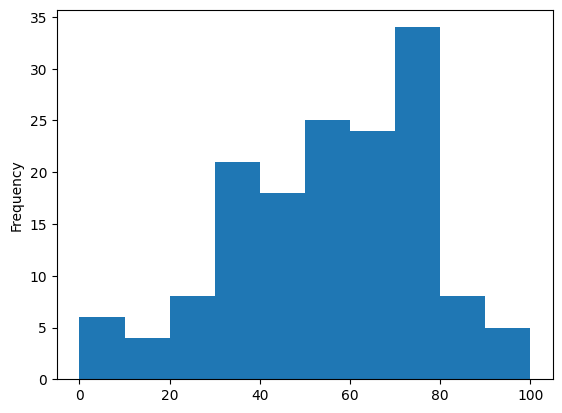

In [44]:
clear_temp_df[clear_temp_df['Hire status']==0]['llm_eval'].plot(kind='hist')
clear_temp_df[clear_temp_df['Hire status']==0]['llm_eval'].mean()

58.67307692307692

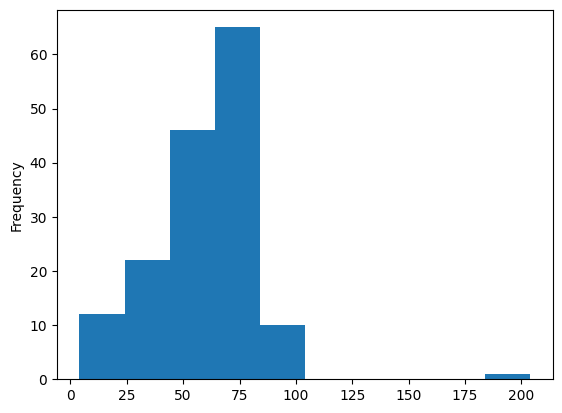

In [45]:
clear_temp_df[clear_temp_df['Hire status']==1]['llm_eval'].plot(kind='hist')
clear_temp_df[clear_temp_df['Hire status']==1]['llm_eval'].mean()

In [ ]:
clear_temp_df[clear_temp_df['Hire status']!=(clear_temp_df['llm_eval']>=40)]

In [49]:
scores = clear_temp_df['llm_eval']
true_labels = clear_temp_df['Hire status']

roc_auc = roc_auc_score(true_labels, scores)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.5503
